In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
from multiprocessing import Pool
from pprint import pprint
from datetime import datetime

In [32]:
total_data = pd.read_csv("stats.csv", parse_dates=[0], index_col=[0])
total_data.current_dir.unique()

array(['/global/cfs/cdirs/jaws/jaws-install/jaws-supervisord-prod',
       'None',
       '/var/udiMount/global/cscratch1/sd/jaws_jtm/jaws-prod/cromwell-executions/jgi_dap_leo/8a854e1f-52c5-4a58-a701-5a7046ceca00/call-trimAlign_expt/shard-23/execution',
       '/var/udiMount/global/cscratch1/sd/jaws_jtm/jaws-prod/cromwell-executions/jgi_dap_leo/8a854e1f-52c5-4a58-a701-5a7046ceca00/call-findPeaks/shard-36/execution',
       '/var/udiMount/global/cscratch1/sd/jaws_jtm/jaws-prod/cromwell-executions/jgi_dap_leo/8a854e1f-52c5-4a58-a701-5a7046ceca00/call-dapStats/shard-36/execution',
       '/var/udiMount/global/cscratch1/sd/jaws_jtm/jaws-prod/cromwell-executions/jgi_dap_leo/8a854e1f-52c5-4a58-a701-5a7046ceca00/call-assignGenes/shard-36/execution',
       '/var/udiMount/global/cscratch1/sd/jaws_jtm/jaws-prod/cromwell-executions/jgi_dap_leo/8a854e1f-52c5-4a58-a701-5a7046ceca00/call-trimAlign_expt/shard-84/execution',
       '/var/udiMount/global/cscratch1/sd/jaws_jtm/jaws-prod/cromwell-execut

In [10]:
total_data.head()
total_data.name.unique()

array(['slurm_script', 'jtm', 'sshd', 'bash', 'tee', 'trim_align.sh',
       'perl', 'samtools', 'sh', 'bowtie2-align-s', 'find_peaks.sh',
       'macs2', 'bamCoverage', 'mv', 'bamPEFragmentSi', 'grep', 'awk',
       'bbduk.sh', 'java', 'shifter', 'reformat.sh'], dtype=object)

In [26]:
def process_pid(data, time='10s', resample='10s'):
    output_data = {}
    # Basic runtime stats
    output_data['start_time'] = str(data.index[0].strftime("%m-%d-%Y %H:%M:%S.%f"))
    output_data['end_time'] = str(data.index[-1].strftime("%m-%d-%Y %H:%M:%S.%f"))
    output_data['runtime_sec'] = float((data.index[-1] - data.index[0]).total_seconds())

    # Copy over metadata once
    for copy_col in ['name', 'cmdline']:
        output_data[copy_col] = str(data[copy_col].iloc[0])
        
    
    # Get a rolling difference over a window
    # We can tune this before saving data to a DB
    cpu_usage = (data['cpu_time_system'] + data['cpu_time_user']).rolling(time).apply(lambda x: x.iloc[-1] - x.iloc[0])
    cpu_usage = cpu_usage.resample(resample).mean()
    iowait_usage = data['iowait'].rolling(time).apply(lambda x: x.iloc[-1] - x.iloc[0])
    iowait_usage = iowait_usage.resample(resample).mean()
    mem_usage = (data['mem_rss'] + data['mem_vms']).resample(resample).max()
    
    
    output_data['timeseries'] = list(cpu_usage.index.to_series().dt.strftime("%m-%d-%Y %H:%M:%S.%f"))
    output_data['cpu_usage'] = list(cpu_usage)
    output_data['iowait_usage'] = list(iowait_usage)
    output_data['mem_usage'] = list(mem_usage)

    # Reads and writes also need to get differences
    # Will probabaly also need to get units correct
    for read_write in ['read', 'write']:
        for count_chars in ['count', 'chars']:
            output_data[f'{read_write}_{count_chars}_diff'] = list(data[f'{read_write}_{count_chars}'].rolling(
                time).apply(lambda x: x.iloc[-1] - x.iloc[0]))

    # Other columns can be copied over
    for copy_col in ['num_threads', 'num_fds']:
        output_data[copy_col] = list(data[copy_col])

    try:
        return output_data
    except Exception as e:
        logging.debug(e)


In [27]:
total = total_data.groupby('pid').apply(process_pid, '1s', '1s')

In [21]:
total

pid
4132     {'start_time': '02-10-2022 12:43:13.841133', '...
4141     {'start_time': '02-10-2022 12:43:13.843352', '...
4187     {'start_time': '02-10-2022 12:42:07.235091', '...
4252     {'start_time': '02-10-2022 12:42:07.237107', '...
4569     {'start_time': '02-10-2022 12:43:48.010604', '...
                               ...                        
62022    {'start_time': '02-10-2022 12:43:44.452522', '...
62029    {'start_time': '02-10-2022 12:43:44.465531', '...
62034    {'start_time': '02-10-2022 12:43:44.478629', '...
62140    {'start_time': '02-10-2022 12:42:03.792769', '...
64161    {'start_time': '02-10-2022 12:42:04.800146', '...
Length: 206, dtype: object

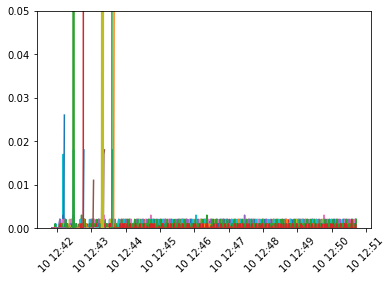

In [29]:

for x in total:
    timeseries = x['timeseries']
    cpu_usage = np.array(x['cpu_usage'])/10
    time = np.array([datetime.strptime(t, "%m-%d-%Y %H:%M:%S.%f") for t in timeseries])
    plt.plot(time, cpu_usage)
plt.xticks(rotation = 45)
plt.ylim(0, 0.05)
plt.show()

In [ ]:
timeseries = total[29544]['timeseries']
mem_usage = total[29544]['mem_usage']
time = np.array([datetime.strptime(t, "%m-%d-%Y %H:%M:%S.%f") for t in timeseries])

print(len(time))

plt.plot(time, mem_usage)
plt.xticks(rotation = 45)
plt.show()

In [ ]:
timeseries = total[29544]['timeseries']
cpu_usage = np.array(total[29544]['iowait_usage'])
time = np.array([datetime.strptime(t, "%m-%d-%Y %H:%M:%S.%f") for t in timeseries])

print(len(time))

plt.plot(time, cpu_usage)
plt.xticks(rotation = 45)

plt.show()

In [ ]:
timeseries = total[29544]['timeseries']
cpu_usage = total[29544]['mem_usage']
time = np.array([datetime.strptime(t, "%m-%d-%Y %H:%M:%S.%f") for t in timeseries])

print(len(time))

plt.plot(time, cpu_usage)
plt.xticks(rotation = 45)
plt.show()

In [ ]:
total_data.cpu_time_user.plot()